<a href="https://colab.research.google.com/github/Calcifer777/learn-rl/blob/main/actor_critic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%%bash

apt install -q xvfb python-opengl ffmpeg

Reading package lists...
Building dependency tree...
Reading state information...
python-opengl is already the newest version (3.1.0+dfsg-2build1).
ffmpeg is already the newest version (7:4.2.7-0ubuntu0.1).
xvfb is already the newest version (2:1.20.13-1ubuntu1~20.04.8).
0 upgraded, 0 newly installed, 0 to remove and 24 not upgraded.


In [2]:
pip -q install gymnasium gym-notebook-wrapper renderlab

In [3]:
from collections import namedtuple
from datetime import datetime
import logging
from typing import List

import gymnasium as gym
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical
from matplotlib import pyplot as plt
import renderlab

In [71]:
RANDOM_SEED = 42
DISCOUNT = 0.99
NUM_EPISODES = 1000
NUM_LOGS = 20
LOG_INTERVAL = NUM_EPISODES // NUM_LOGS
T = 500
RUNNING_REWARD_COEF = 0.05
EPS = np.finfo(np.float32).eps.item()
LR = 2e-3

LOG_TEMPLATE = (
    "Episode {ep_idx:03}\t"
    "Last reward: {ep_reward:.2f}\t"
    "Average reward: {running_reward:.2f}"
)

In [72]:
SavedAction = namedtuple("SavedAction", ["log_prob", "value"])

In [73]:
class Policy(nn.Module):
  def __init__(self, inputs_dim, hidden_dim, outputs_dim):
    super(Policy, self).__init__()
    self.l1 = nn.Linear(inputs_dim, out_features=hidden_dim)
    self.l2 = nn.Linear(hidden_dim, out_features=hidden_dim)
    
    self.action_head = nn.Linear(hidden_dim, outputs_dim)
    self.value_head = nn.Linear(hidden_dim, 1)
    
    self.saved_actions: List[SavedAction] = []
    self.rewards = []

  def forward(self, x):
    h = self.l1(x)
    h = F.relu(h)
    h = self.l2(h)
    action_probs = F.softmax(self.action_head(h), dim=-1)
    values = self.value_head(h)
    return action_probs, values

In [74]:
# Test model
policy = Policy(inputs_dim=4, hidden_dim=64, outputs_dim=2)
sample = torch.rand((1, 4))
policy(sample)

(tensor([[0.4331, 0.5669]], grad_fn=<SoftmaxBackward0>),
 tensor([[0.0114]], grad_fn=<AddmmBackward0>))

In [75]:
def select_action(policy, state):
  state = torch.from_numpy(state).float()
  probs, value = policy(state)

  action_distr = Categorical(probs)
  action = action_distr.sample()

  policy.saved_actions.append(
      SavedAction(action_distr.log_prob(action), value)
  )

  return action.item()

In [76]:
env = gym.make("CartPole-v1")
env.reset(seed=RANDOM_SEED)

(array([ 0.0273956 , -0.00611216,  0.03585979,  0.0197368 ], dtype=float32),
 {})

In [77]:
# Test action selection
state, _ = env.reset()
action = select_action(policy, state)
env.step(action)

(array([-0.03963102, -0.14792429,  0.0266861 ,  0.32941288], dtype=float32),
 1.0,
 False,
 False,
 {})

In [78]:
def run_episode(env, policy: Policy, max_time_steps: int=T):

  state, _ = env.reset()
  ep_reward = 0

  for t in range(max_time_steps):
    action = select_action(policy, state)
    state, reward, done, _, _ = env.step(action)
    policy.rewards.append(reward)

    ep_reward += reward

    if done:
      break
  
  return ep_reward

In [79]:
# Test run episode
policy = Policy(inputs_dim=4, hidden_dim=64, outputs_dim=2)
run_episode(env, policy)

16.0

In [80]:
def backprop(policy: Policy, optimizer):
  actions = policy.saved_actions
  rewards = policy.rewards

  losses_policy, losses_value = [], []

  # For each step, compute its value
  values = []
  accumulated_return = 0
  for reward in reversed(policy.rewards):
    accumulated_return = reward + DISCOUNT * accumulated_return
    values.append(accumulated_return)
  values = list(reversed(values))
  values = torch.tensor(values)
  values = (values - values.mean()) / (values.std() + EPS)

  # For each step, compute the loss
  for (logit, value_hat), value in zip(actions, values):
    advantage = value - value_hat.item()
    losses_policy.append(-logit * advantage)
    losses_value.append(F.smooth_l1_loss(value_hat, torch.tensor([value])))

  loss = (
      torch.stack(losses_policy).sum() +
      torch.stack(losses_value).sum()
  )

  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  del policy.saved_actions[:]
  del policy.rewards[:]

  return loss


In [81]:
# Test backprop
env = gym.make("CartPole-v1")
env.reset(seed=RANDOM_SEED)

policy = Policy(inputs_dim=4, hidden_dim=64, outputs_dim=2)
optimizer = optim.Adam(policy.parameters(), 1e-2)
run_episode(env, policy)
backprop(policy, optimizer)

tensor(11.9012, grad_fn=<AddBackward0>)

In [82]:
torch.random.manual_seed(RANDOM_SEED)

# Test backprop
env = gym.make("CartPole-v1", render_mode="rgb_array")
env.reset(seed=RANDOM_SEED)

policy = Policy(inputs_dim=4, hidden_dim=128, outputs_dim=2)
optimizer = optim.Adam(policy.parameters(), LR)

In [84]:
losses = []
rewards = []

running_reward = 0

for ep_idx in range(NUM_EPISODES):

  ep_reward = run_episode(env, policy)
  rewards.append(ep_reward)
  
  loss = backprop(policy, optimizer)
  losses.append(loss.item())

  running_reward = (
      RUNNING_REWARD_COEF * ep_reward + 
      (1-RUNNING_REWARD_COEF) * running_reward
  )
  if ep_idx % LOG_INTERVAL == 0:
    log_txt = LOG_TEMPLATE.format(
      ep_idx=ep_idx, 
      ep_reward=ep_reward, 
      running_reward=running_reward,
    )
    logging.warning(log_txt)

  if running_reward > env.spec.reward_threshold:
    logging.warning(
      f"Solved! Running reward is now {running_reward} and "
      f"the last episode runs to {ep_idx} time steps!"
    )
    break


In [85]:
def running_mean(x, N = 50):
  kernel = np.ones(N)
  conv_len = x.shape[0]-N
  y = np.zeros(conv_len)
  for i in range(conv_len):
    y[i] = kernel @ x[i:i+N]
    y[i] /= N
  return y

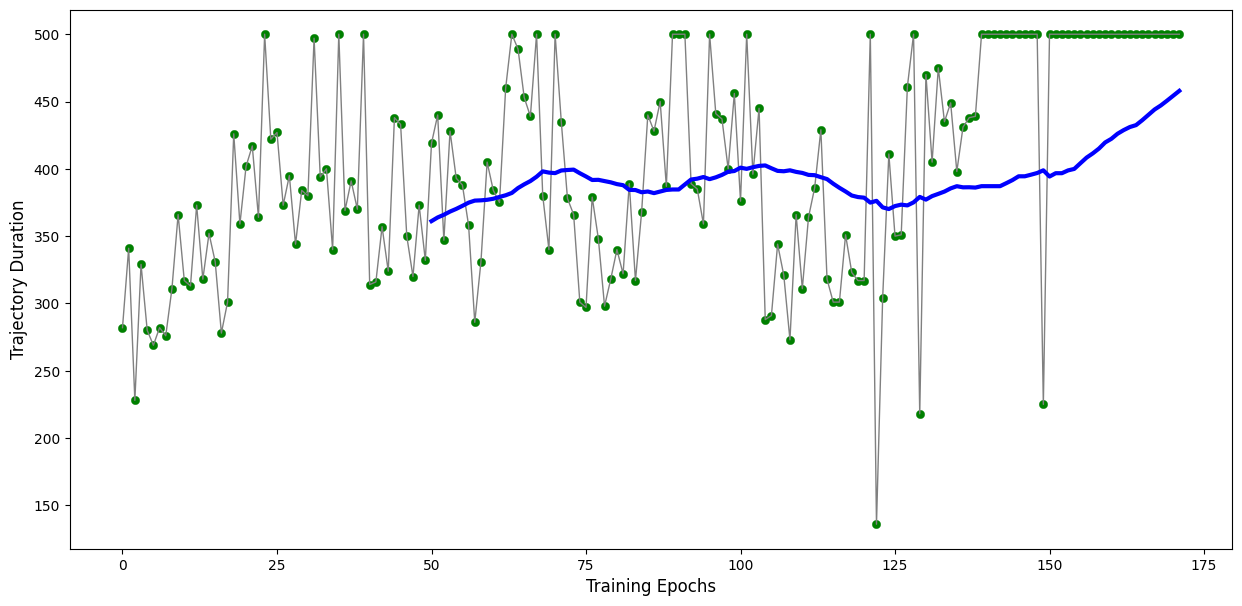

In [86]:
score = np.array(rewards)
plt.figure(figsize=(15,7))
plt.ylabel("Trajectory Duration",fontsize=12)
plt.xlabel("Training Epochs",fontsize=12)
plt.plot(score, color='gray' , linewidth=1)
plt.scatter(
  np.arange(score.shape[0]),
  score, 
  color='green', 
  linewidth=0.3
)

window = 50
avg_score = running_mean(score, window)
plt.plot(np.arange(len(avg_score))+window, avg_score, color='blue', linewidth=3)

In [87]:
ts = datetime.utcnow().isoformat()
env_rendered = renderlab.RenderFrame(env, directory=f"./actor-critic-{ts}")
run_episode(env_rendered, policy)
env_rendered.play()

Moviepy - Building video temp-{start}.mp4.
Moviepy - Writing video temp-{start}.mp4



Moviepy - Done !
Moviepy - video ready temp-{start}.mp4
